In [4]:
# 1. import packages and add global parameter settings
# 2. fetch all the runs from wandb
import re
import json
import numpy as np
from io import StringIO
from tqdm.auto import tqdm
import wandb
import string
import nltk
import seaborn as sb
import matplotlib.pyplot as plt
import simplejson
import pandas as pd
from datasets import load_dataset
from matplotlib.ticker import FuncFormatter
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import defaultdict


sb.set_theme(style="white", palette=None)


# connect to wandb and get list of runs
api_helper = wandb.Api(api_key='3138e1b24deb278ed045d0dedb39511d3a96245b')
runs = list(api_helper.runs(path='yuting_fyp/In-context-learning for Dialogue Summarization',
                     per_page=1000))
runs

[<Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/fntrr5tr (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/gjv96qdx (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/dmaaa18x (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/wg2h7ngs (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/1fiac1o4 (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/957al3yu (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/u8k2vcpu (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/wxdnlyou (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/7ij9vft9 (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/84bqldcq (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summarization/2lj9otkn (finished)>,
 <Run yuting_fyp/In-context-learning+for+Dialogue+Summ

In [9]:
# iterate over completed runs to get ROUGE scores tables
run2metric_table = {}
for run in tqdm(runs):
    if 'complete' not in run.tags or 'evaluation' != getattr(run, 'job_type', ''):
        continue
    else:
        print('parsing run {}'.format(run.name))
    # download the rouge table
    files = run.files()
    metric_file = [file for file in files if 'Evaluation metrics Table' in getattr(file, 'name', '')]
    if len(metric_file) < 1:
        print('[WARN] skip {} because len(metric_file) < 1'.format(metric_file))
        continue
    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metric_table = pd.read_json(simplejson.dumps(metrics, ignore_nan=True), orient='split')
    # get k shot
    try:
        match = re.search(r'\d-shot', run.name)
        start_i, end_i = match.span()
        k = int(run.name[start_i: end_i].split('-')[0])
        metric_table['k'] = k
    except AttributeError:
        print('[debug] skip {}'.format(run.name))
        continue 
    model_name = run.name[: start_i - 1]
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None

    run2metric_table[run.name] = metric_table
run2metric_table

  0%|          | 0/325 [00:00<?, ?it/s]

parsing run opt-1.3b-3-shot-3-keywords
[debug] find keyword_num = 3 in opt-1.3b-3-shot-3-keywords
parsing run opt-1.3b-3-shot-2-keywords
[debug] find keyword_num = 2 in opt-1.3b-3-shot-2-keywords
parsing run opt-1.3b-3-shot-1-keywords
[debug] find keyword_num = 1 in opt-1.3b-3-shot-1-keywords
parsing run Cerebras-GPT-6.7B-3-shot-3-keywords
[debug] find keyword_num = 3 in Cerebras-GPT-6.7B-3-shot-3-keywords
parsing run Cerebras-GPT-6.7B-2-shot-flipLabel
parsing run llama-7b-hf-2-shot-flipLabel
parsing run mt5-xl-3-shot-focus
parsing run mt5-xl-2-shot-focus


KeyboardInterrupt: 

In [5]:
metrics

{'columns': ['run_id',
  'rouge_1_precision',
  'rouge_1_recall',
  'rouge_1_fmeasure',
  'rouge_2_precision',
  'rouge_2_recall',
  'rouge_2_fmeasure',
  'rouge_L_precision',
  'rouge_L_recall',
  'rouge_L_fmeasure'],
 'data': [[0,
   0.43700895508275067,
   0.33084417709954983,
   0.3395551768758901,
   0.11883635810491792,
   0.0840672569429876,
   0.08777556677567548,
   0.32518775006419365,
   0.24122348617445127,
   0.24874259787467645],
  [1,
   0.4309530090318445,
   0.3321454515090304,
   0.3381649920895884,
   0.11414005413496973,
   0.08180340366583774,
   0.08483216580873428,
   0.32178251668575075,
   0.24357206628861292,
   0.2486506489057433],
  [2,
   0.43811355374629735,
   0.3325471498727204,
   0.34441577092527054,
   0.11739738875331317,
   0.08650603778464096,
   0.09062174739052,
   0.32791971176960943,
   0.24265784839707388,
   0.2537369016158516],
  [3, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  [4, nan, nan, nan, nan, nan, nan, nan, nan, nan]]}

# Direct prompt

In [41]:
# parse the result of direct prompt
new_keys = [x for x in run2metric_table.keys() if ('keyword' not in x and 'nameReplace' not in x and 'length' 
                                                   not in x and 'replaceName' not in x and 'instructions' not in x and 
                                                  'focus' not in x and 'randomLabel' not in x)]
# new_keys = [x for x in run2metric_table.keys() if ('keyword' not in x and 'nameReplace' not in x and 'length' not
#                                                     in x and 'replaceName' not in x and 'instructions' not in x and 'focus' in x)]

dfs = [run2metric_table[k] for k in new_keys]
rouge_table = pd.concat(dfs, axis=0, ignore_index=True)
rouge_table['k'] = rouge_table['k'].astype(int)
rouge_table['keyword_num'] = rouge_table['keyword_num'].fillna(0)
rouge_table = rouge_table[(rouge_table['k'] <= 3) & ~rouge_table.isna().any(axis=1)]
rouge_table = rouge_table[~rouge_table['model_name'].str.contains('Cerebras-GPT-6.7B') & ~rouge_table['model_name'].str.contains('flan-t5-xl')]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot = sb.lineplot(data=rouge_table, x='k', y='rouge_1_fmeasure', hue='model_name', ax=axes[0], markers=True)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[0].get_legend().remove()
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_2_fmeasure', hue='model_name', ax=axes[1], markers=True)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[1].get_legend().remove()
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plot = sb.lineplot(data=rouge_table, x='k', y='rouge_L_fmeasure', hue='model_name', ax=axes[2], markers=True)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[2].get_legend().remove()
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', ncol=3, bbox_to_anchor=(.75, 0.98))

plt.savefig('direct_prompt.jpg', dpi=500, bbox_inches='tight')

ValueError: No objects to concatenate

In [ ]:
new_keys

In [ ]:
rouge_table.groupby(['model_name', 'k']).mean().to_csv('mean.csv')

In [ ]:
rouge_table.groupby(['model_name', 'k']).std().to_csv('std.csv')

In [ ]:
rouge_table.groupby(['model_name', 'k']).mean()

In [ ]:
rouge_table.groupby(['model_name', 'k']).std()

# Plot results under controlled setting

In [42]:
# iterate over completed runs to get ROUGE scores tables
run2metric_table = {}
for run in tqdm(runs):
    if 'complete' not in run.tags or 'evaluation' != getattr(run, 'job_type', '') or 'keyword' not in run.name:
        continue
    else:
        print('parsing run {}'.format(run.name))
    # download the rouge table
    files = run.files()
    metric_file = [file for file in files if 'Evaluation metrics Table' in getattr(file, 'name', '')]
    if len(metric_file) < 1:
        print('[WARN] skip {} because len(metric_file) < 1'.format(metric_file))
        continue
    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metric_table = pd.read_json(simplejson.dumps(metrics, ignore_nan=True), orient='split')
    # get k shot
    try:
        match = re.search(r'\d-shot', run.name)
        start_i, end_i = match.span()
        k = int(run.name[start_i: end_i].split('-')[0])
        metric_table['k'] = k
    except AttributeError:
        print('[debug] skip {}'.format(run.name))
        continue 
    model_name = run.name[: start_i - 1]
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None
    
    # add model information to metric_table
    metric_table['model_type'] = run.config['model_type']
    run2metric_table[run.name] = metric_table
run2metric_table

  0%|          | 0/325 [00:00<?, ?it/s]

parsing run opt-1.3b-3-shot-3-keywords
[debug] find keyword_num = 3 in opt-1.3b-3-shot-3-keywords
parsing run opt-1.3b-3-shot-2-keywords
[debug] find keyword_num = 2 in opt-1.3b-3-shot-2-keywords
parsing run opt-1.3b-3-shot-1-keywords
[debug] find keyword_num = 1 in opt-1.3b-3-shot-1-keywords
parsing run Cerebras-GPT-6.7B-3-shot-3-keywords
[debug] find keyword_num = 3 in Cerebras-GPT-6.7B-3-shot-3-keywords
parsing run alpaca-native-0-shot-3-keywords
[debug] find keyword_num = 3 in alpaca-native-0-shot-3-keywords
parsing run llama-7b-hf-0-shot-3-keywords
[debug] find keyword_num = 3 in llama-7b-hf-0-shot-3-keywords
parsing run opt-iml-1.3b-0-shot-3-keywords
[debug] find keyword_num = 3 in opt-iml-1.3b-0-shot-3-keywords
parsing run opt-iml-1.3b-0-shot-2-keywords
[debug] find keyword_num = 2 in opt-iml-1.3b-0-shot-2-keywords
parsing run opt-iml-1.3b-0-shot-1-keywords
[debug] find keyword_num = 1 in opt-iml-1.3b-0-shot-1-keywords
parsing run mt5-xl-1-shot-3-keywords-raw
[debug] find keywor

[debug] find keyword_num = 1 in opt-iml-1.3b-1-shot-1-keywords
parsing run mt5-xxl-3-shot-3-keywords
[debug] find keyword_num = 3 in mt5-xxl-3-shot-3-keywords
parsing run mt5-xxl-3-shot-2-keywords
[debug] find keyword_num = 2 in mt5-xxl-3-shot-2-keywords
parsing run opt-iml-1.3b-2-shot-1-keywords
[debug] find keyword_num = 1 in opt-iml-1.3b-2-shot-1-keywords
parsing run opt-iml-1.3b-2-shot-2-keywords
[debug] find keyword_num = 2 in opt-iml-1.3b-2-shot-2-keywords
parsing run opt-iml-1.3b-1-shot-3-keywords
[debug] find keyword_num = 3 in opt-iml-1.3b-1-shot-3-keywords
parsing run opt-iml-1.3b-1-shot-2-keywords
[debug] find keyword_num = 2 in opt-iml-1.3b-1-shot-2-keywords
parsing run opt-iml-1.3b-1-shot-3-keywords
[debug] find keyword_num = 3 in opt-iml-1.3b-1-shot-3-keywords
parsing run opt-iml-1.3b-2-shot-3-keywords
[debug] find keyword_num = 3 in opt-iml-1.3b-2-shot-3-keywords
parsing run mt5-xxl-3-shot-1-keywords
[debug] find keyword_num = 1 in mt5-xxl-3-shot-1-keywords
parsing run m

{'opt-1.3b-3-shot-3-keywords':    run_id  rouge_1_precision  rouge_1_recall  rouge_1_fmeasure  \
 0       0           0.437009        0.330844          0.339555   
 1       1           0.430953        0.332145          0.338165   
 2       2           0.438114        0.332547          0.344416   
 3       3                NaN             NaN               NaN   
 4       4                NaN             NaN               NaN   
 
    rouge_2_precision  rouge_2_recall  rouge_2_fmeasure  rouge_L_precision  \
 0           0.118836        0.084067          0.087776           0.325188   
 1           0.114140        0.081803          0.084832           0.321783   
 2           0.117397        0.086506          0.090622           0.327920   
 3                NaN             NaN               NaN                NaN   
 4                NaN             NaN               NaN                NaN   
 
    rouge_L_recall  rouge_L_fmeasure  k keyword_num         model_type  
 0        0.241223     

[debug] new_keys = ['Cerebras-GPT-13B-1-shot-1-keywords', 'Cerebras-GPT-13B-1-shot-2-keywords', 'Cerebras-GPT-13B-1-shot-3-keywords', 'Cerebras-GPT-13B-2-shot-1-keywords', 'Cerebras-GPT-13B-2-shot-2-keywords', 'Cerebras-GPT-13B-2-shot-3-keywords', 'Cerebras-GPT-13B-3-shot-1-keywords', 'Cerebras-GPT-13B-3-shot-2-keywords', 'Cerebras-GPT-13B-3-shot-3-keywords', 'Cerebras-GPT-2.7B-1-shot-1-keywords', 'Cerebras-GPT-2.7B-1-shot-2-keywords', 'Cerebras-GPT-2.7B-1-shot-3-keywords', 'Cerebras-GPT-2.7B-2-shot-1-keywords', 'Cerebras-GPT-2.7B-2-shot-2-keywords', 'Cerebras-GPT-2.7B-2-shot-3-keywords', 'Cerebras-GPT-2.7B-3-shot-1-keywords', 'Cerebras-GPT-2.7B-3-shot-2-keywords', 'Cerebras-GPT-2.7B-3-shot-3-keywords', 'Cerebras-GPT-6.7B-1-shot-1-keywords', 'Cerebras-GPT-6.7B-1-shot-2-keywords', 'Cerebras-GPT-6.7B-1-shot-3-keywords', 'Cerebras-GPT-6.7B-2-shot-1-keywords', 'Cerebras-GPT-6.7B-2-shot-2-keywords', 'Cerebras-GPT-6.7B-2-shot-3-keywords', 'Cerebras-GPT-6.7B-3-shot-1-keywords', 'Cerebras-GPT-

C:\Users\chris\Desktop\CodeRepositories\venv\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
C:\Users\chris\Desktop\CodeRepositories\venv\lib\site-packages\ipykernel_launcher.py:31: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
C:\Users\chris\Desktop\CodeRepositories\venv\lib\site-packages\ipykernel_launcher.py:35: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.


,run_id,rouge_1_precision,rouge_1_recall,rouge_1_fmeasure,rouge_2_precision,rouge_2_recall,rouge_2_fmeasure,rouge_L_precision,rouge_L_recall,rouge_L_fmeasure,k,keyword_num,model_type
0,0,0.437009,0.330844,0.339555,0.118836,0.084067,0.087776,0.325188,0.241223,0.248743,3,3,facebook/opt-1.3b
1,1,0.430953,0.332145,0.338165,0.114140,0.081803,0.084832,0.321783,0.243572,0.248651,3,3,facebook/opt-1.3b
2,2,0.438114,0.332547,0.344416,0.117397,0.086506,0.090622,0.327920,0.242658,0.253737,3,3,facebook/opt-1.3b
5,0,0.415053,0.330226,0.329144,0.106577,0.080205,0.080772,0.310042,0.242130,0.242610,3,2,facebook/opt-1.3b
6,1,0.416341,0.325805,0.329980,0.107148,0.078733,0.079692,0.313354,0.240218,0.244370,3,2,facebook/opt-1.3b
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,0,0.292010,0.420914,0.322290,0.100288,0.144227,0.109819,0.246213,0.351452,0.270294,1,1,google/mt5-xl
452,1,0.296435,0.426180,0.327425,0.104588,0.147207,0.113555,0.248779,0.355695,0.273559,1,1,google/mt5-xl
453,2,0.295440,0.430054,0.328151,0.103256,0.148017,0.113052,0.248954,0.358307,0.275051,1,1,google/mt5-xl
454,3,0.296828,0.424162,0.327956,0.102463,0.144417,0.111743,0.249440,0.353135,0.274150,1,1,google/mt5-xl


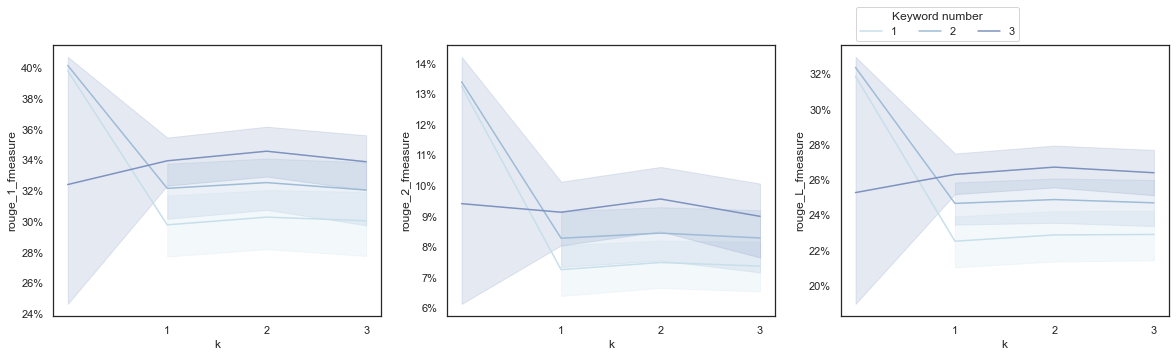

In [45]:
# get the result of MODEL_NAME family
MODEL_NAME = None

if MODEL_NAME == 'mt5-xl':
    new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'mt5-xxl' not in x]
elif MODEL_NAME is None:
    new_keys = [x for x in run2metric_table.keys() if  'nameReplace' not in x and 'focus' not in x and 'replaceName' not in x and 'raw' not in x]
else:
#     new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'nameReplace' not in x and 'length' not in x and 'replaceName' not in x]
#     new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'nameReplace' not in x and 'length' in x and 'replaceName' not in x]
    new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'nameReplace' not in x and 'focus' in x and 'replaceName' not in x]

print('[debug] new_keys =', sorted(new_keys))
dfs = [run2metric_table[k] for k in new_keys]
rouge_table = pd.concat(dfs, axis=0, ignore_index=True)
rouge_table['k'] = rouge_table['k'].astype(int)
rouge_table['keyword_num'] = rouge_table['keyword_num'].fillna(0)
rouge_table['keyword_num'] = rouge_table['keyword_num'].astype(int)
rouge_table = rouge_table[~rouge_table.isna().any(axis=1)]

rouge_table = rouge_table[(rouge_table['k'] <= 3)]
# rouge_table = rouge_table[~rouge_table['model_name'].str.contains('Cerebras-GPT-6.7B')]

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
palette = sb.color_palette("ch:s=.25,rot=-.25", as_cmap=False)

plot = sb.lineplot(data=rouge_table, x='k', y='rouge_1_fmeasure', hue='keyword_num', ax=axes[0], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_2_fmeasure', hue='keyword_num', ax=axes[1], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_L_fmeasure', hue='keyword_num', ax=axes[2], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=5, bbox_to_anchor=(.8, 1), title='Keyword number')
fig.suptitle(MODEL_NAME, fontweight='bold')
#
plt.savefig('{}_entity_control.jpg'.format(MODEL_NAME), dpi=500, bbox_inches='tight')

rouge_table

In [23]:
mean_df = rouge_table.groupby('k').mean() * 100
mean_df[[x for x in mean_df.columns if 'fmeasure' in x]]

,rouge_1_fmeasure,rouge_2_fmeasure,rouge_L_fmeasure
k,,,
0,35.430567,10.971229,28.008201
1,31.404003,7.645111,23.709003
2,32.340805,8.262679,24.499556
3,31.813178,7.915826,24.243753


In [24]:
std_df = rouge_table.groupby('k').std() * 100
std_df[[x for x in std_df.columns if 'fmeasure' in x]]

,rouge_1_fmeasure,rouge_2_fmeasure,rouge_L_fmeasure
k,,,
0,7.042444,3.684668,6.269991
1,6.723052,3.049433,4.387394
2,6.946434,3.508179,4.926686
3,7.037936,3.406898,4.777506


In [ ]:
[x for x in run2metric_table.keys() if 'Cerebras-GPT-6.7B' in x]

In [54]:
average_values.columns 

Index(['rouge_1_fmeasure', 'rouge_2_fmeasure', 'rouge_L_fmeasure'], dtype='object')

## Get the entity contro table

In [46]:
groups = rouge_table.groupby(['model_type', 'keyword_num'])

In [55]:
average_values = groups.mean()
average_values = average_values.drop(['GPT3-davinci-003', 'cerebras/Cerebras-GPT-2.7B', 'cerebras/Cerebras-GPT-13B', 'google/mt5-xxl'], axis=0)
average_values = average_values[['rouge_1_fmeasure', 'rouge_2_fmeasure', 'rouge_L_fmeasure']]
average_values = average_values * 100
# change the column name 
average_values.columns = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
average_values

ROUGE-1    ROUGE-2    ROUGE-L
model_type                    keyword_num                                 
bigscience/bloom-7b1          1            32.222030   7.606253  23.152424
                              2            34.929827   9.169437  25.646008
                              3            36.621431  10.215574  27.204085
cerebras/Cerebras-GPT-6.7B    1            32.558974   7.672147  23.200642
                              2            33.925956   8.548236  24.491141
                              3            35.951494   9.742888  26.007582
chavinlo/alpaca-native        1            33.330362   7.634886  24.719082
                              2            35.149442   8.917378  26.318892
                              3            35.942313   9.603988  27.134118
decapoda-research/llama-7b-hf 1            32.001227   7.756898  23.388921
                              2            33.595771   8.783019  24.839838
                              3            34.117155   9.307553  25.438838
facebook/opt-1.3b             1            30.024707   6.400597  22.102019
                              2            32.073947   7.680635  23.665296
                              3            33.230077   8.194960  24.470524
facebook/opt-iml-1.3b         1            36.537169  10.950998  29.542825
                              2            36.905158  11.080611  29.591006
                              3            37.823137  11.613879  30.515628
google/mt5-xl                 1            32.293648  10.899978  27.528346
                              2            36.295301  13.043554  31.387977
                              3            39.788237  15.230532  34.571282

In [51]:
average_values = groups.std()
average_values = average_values.drop(['GPT3-davinci-003', 'cerebras/Cerebras-GPT-2.7B', 'cerebras/Cerebras-GPT-13B', 'google/mt5-xxl'], axis=0)
average_values[['rouge_1_fmeasure', 'rouge_2_fmeasure', 'rouge_L_fmeasure']]

rouge_1_fmeasure  rouge_2_fmeasure  \
model_type                    keyword_num                                       
bigscience/bloom-7b1          1                    0.003302          0.002417   
                              2                    0.003310          0.002405   
                              3                    0.004329          0.002946   
cerebras/Cerebras-GPT-6.7B    1                    0.002508          0.003799   
                              2                    0.014355          0.007212   
                              3                    0.002840          0.002758   
chavinlo/alpaca-native        1                    0.005000          0.002140   
                              2                    0.004031          0.003042   
                              3                    0.011854          0.005256   
decapoda-research/llama-7b-hf 1                    0.006429          0.003536   
                              2                    0.006803          0.003107   
                              3                    0.026336          0.009134   
facebook/opt-1.3b             1                    0.014380          0.006924   
                              2                    0.009288          0.005225   
                              3                    0.007777          0.005232   
facebook/opt-iml-1.3b         1                    0.017108          0.019889   
                              2                    0.015183          0.013371   
                              3                    0.014486          0.019724   
google/mt5-xl                 1                    0.004293          0.002731   
                              2                    0.007728          0.003269   
                              3                    0.011015          0.004491   

                                           rouge_L_fmeasure  
model_type                    keyword_num                    
bigscience/bloom-7b1          1                    0.003492  
                              2                    0.002949  
                              3                    0.003423  
cerebras/Cerebras-GPT-6.7B    1                    0.004492  
                              2                    0.003583  
                              3                    0.002960  
chavinlo/alpaca-native        1                    0.004012  
                              2                    0.003581  
                              3                    0.009548  
decapoda-research/llama-7b-hf 1                    0.004995  
                              2                    0.005479  
                              3                    0.018253  
facebook/opt-1.3b             1                    0.006929  
                              2                    0.006986  
                              3                    0.005263  
facebook/opt-iml-1.3b         1                    0.012666  
                              2                    0.014194  
                              3                    0.010496  
google/mt5-xl                 1                    0.002829  
                              2                    0.004389  
                              3                    0.007734

In [57]:
print(average_values.to_latex(float_format="{:0.2f}".format))

\begin{tabular}{llrrr}
\toprule
              &   &  ROUGE-1 &  ROUGE-2 &  ROUGE-L \\
model\_type & keyword\_num &          &          &          \\
\midrule
bigscience/bloom-7b1 & 1 &    32.22 &     7.61 &    23.15 \\
              & 2 &    34.93 &     9.17 &    25.65 \\
              & 3 &    36.62 &    10.22 &    27.20 \\
cerebras/Cerebras-GPT-6.7B & 1 &    32.56 &     7.67 &    23.20 \\
              & 2 &    33.93 &     8.55 &    24.49 \\
              & 3 &    35.95 &     9.74 &    26.01 \\
chavinlo/alpaca-native & 1 &    33.33 &     7.63 &    24.72 \\
              & 2 &    35.15 &     8.92 &    26.32 \\
              & 3 &    35.94 &     9.60 &    27.13 \\
decapoda-research/llama-7b-hf & 1 &    32.00 &     7.76 &    23.39 \\
              & 2 &    33.60 &     8.78 &    24.84 \\
              & 3 &    34.12 &     9.31 &    25.44 \\
facebook/opt-1.3b & 1 &    30.02 &     6.40 &    22.10 \\
              & 2 &    32.07 &     7.68 &    23.67 \\
              & 3 &    33.23 &     8.

# Get Success Rate

In [3]:
# iterate over completed runs to get summaries table
MODEL_FAMILY = ['facebook/opt-1.3b']  # huggingface path

run2metric_table = {}
for run in tqdm(runs):
    if 'complete' not in run.tags or run.config['model_type'] not in MODEL_FAMILY or run.job_type != 'evaluation':
        continue
    
    # adjust the boolean expression if needed 
    if 'nameReplace' in run.name or 'length' in run.name or 'replaceName' in run.name or \
        'randomLabel' in run.name or 'focus' in run.name or 'numeric' in run.name:
        continue  
        
    print('parsing run {}'.format(run.name))
    files = run.files()
    metric_file = [file for file in files if 'Summaries Table' in getattr(file, 'name', '')]
    print([file.name for file in files])
    if len(metric_file) < 1:
        print('[WARN] skip {} because len(metric_file) >= 1'.format(metric_file))
        continue 
    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metrics = json.dumps(metrics)
    metric_table = pd.read_json(StringIO(metrics), orient='split')
    # get k shot
    match = re.search(r'\d-shot', run.name)
    start_i, end_i = match.span()
    k = int(run.name[start_i: end_i].split('-')[0])

    metric_table['k'] = k
    model_name = run.name[: start_i - 1]
    metric_table['model_name'] = model_name
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None

    run2metric_table[run.name] = metric_table
run2metric_table

  0%|          | 0/317 [00:00<?, ?it/s]

parsing run opt-1.3b-2-shot-3-keywords
['artifact/477130634/wandb_manifest.json', 'artifact/477130654/wandb_manifest.json', 'config.yaml', 'media/table/Evaluation metrics Table_0_a179d933c87fcf0fb04e.table.json', 'media/table/Summaries Table_1_eadcc4375741818a2273.table.json', 'output.log', 'requirements.txt', 'wandb-metadata.json', 'wandb-summary.json']
[debug] find keyword_num = 3 in opt-1.3b-2-shot-3-keywords
parsing run opt-1.3b-2-shot-1-keywords
['artifact/477129919/wandb_manifest.json', 'artifact/477129941/wandb_manifest.json', 'config.yaml', 'media/table/Evaluation metrics Table_0_fe1d14aafd7ef327051f.table.json', 'media/table/Summaries Table_1_988c6721190ef73ef5ca.table.json', 'output.log', 'requirements.txt', 'wandb-metadata.json', 'wandb-summary.json']
[debug] find keyword_num = 1 in opt-1.3b-2-shot-1-keywords
parsing run opt-1.3b-2-shot-2-keywords
['artifact/477128728/wandb_manifest.json', 'artifact/477128747/wandb_manifest.json', 'config.yaml', 'media/table/Evaluation metri

{'opt-1.3b-2-shot-3-keywords':       run_id                                             prompt  \
 0          0  Summarize the conversation with keywords:\nJoh...   
 1          0  Summarize the conversation with keywords:\nLis...   
 2          0  Summarize the conversation with keywords:\nLar...   
 3          0  Summarize the conversation with keywords:\nLol...   
 4          0  Summarize the conversation with keywords:\nRob...   
 ...      ...                                                ...   
 4090       4  Summarize the conversation with keywords:\nCar...   
 4091       4  Summarize the conversation with keywords:\nNic...   
 4092       4  Summarize the conversation with keywords:\nJac...   
 4093       4  Summarize the conversation with keywords:\nIan...   
 4094       4  Summarize the conversation with keywords:\nCla...   
 
                                            pred_summary  \
 0     Hannah and Amanda are talking about Betty. Han...   
 1     Eric is a stand up comedi

In [5]:
run2metric_table.keys()

dict_keys(['opt-1.3b-2-shot-3-keywords', 'opt-1.3b-2-shot-1-keywords', 'opt-1.3b-2-shot-2-keywords', 'opt-1.3b-1-shot-3-keywords', 'opt-1.3b-1-shot-2-keywords', 'opt-1.3b-1-shot-1-keywords', 'opt-1.3b-3-shot', 'opt-1.3b-2-shot', 'opt-1.3b-1-shot'])

In [11]:
def stem_sentence(sentence):
    if isinstance(sentence, str):
        # Tokenize the sentence into words
        words = word_tokenize(sentence)
    else:
        words = sentence
    # Initialize the Porter stemmer
    stemmer = PorterStemmer()
    # Stem each word in the sentence
    stemmed_words = [stemmer.stem(word) for word in words]
    # Join the stemmed words back into a sentence
    return stemmed_words

In [6]:
# get the success rate over runs and save the keywords
df = []
missing_keywords2counts = defaultdict(lambda: 0)
included_keywords2counts = defaultdict(lambda: 0)

summary_numerical_num = 0 
response_numerical_num = 0

for run_name, summaries in run2metric_table.items():
    print('[info] parse experiment', run_name)

    summaries['keyword_num'] = summaries['keyword_num'].fillna(0)
    keyword_num = int(summaries['keyword_num'][0])
#     if keyword_num <= 0 or 'keywords' not in run_name:
#         continue  
    if 'nameReplace' in run_name or 'length' in run_name or 'replaceName' in run_name or \
        'randomLabel' in run_name or 'focus' in run_name or 'numeric' in run_name or 'keywords' in run_name:
        continue 

    model_name = summaries['model_name'][0]
    k = summaries['k'][0]

    for run_id, df_ in summaries.groupby('run_id'):
        print('[info] parse run', run_id)
        keywords_num_total = 0
        included_keywords_num = 0

        # iterate over the run
        for _, row in df_.iterrows():
            is_contains_numeric_gold = any(char.isdigit() for char in row['gold_summary'])
            summary_numerical_num += is_contains_numeric_gold
            is_contains_numeric_pred = any(char.isdigit() for char in row['pred_summary'])
            response_numerical_num += is_contains_numeric_pred
            
            last_line = row['prompt'].split('\n')[-1]
            # parse the keywords
            try:
                start_i, end_i = re.search('\[.+\]', last_line).span()
                keywords = [x.strip()[1:-1] for x in last_line[start_i+1:end_i-1].split(',')]
            except AttributeError:  # mt5 keywords are in different format
#                 print('[debug] last_line = {}'.format(last_line))
                last_line = re.sub(r'<extra_id_\d+>', '',last_line)
                last_line = last_line.split('Summary: ', maxsplit=1)[-1]
                keywords = [x for x in last_line.split(' ') if len(x.strip()) >= 1]
                if len(keywords) != keyword_num:
                    print('[debug] skip')
                    continue 
            # stem words
            keywords = stem_sentence(keywords)
            gold_summary = stem_sentence(row['pred_summary'])  # fixme: wrong name 
            # check if keywords are included
            keywords_num_total += len(keywords)
            for keyword in keywords:
                if keyword in gold_summary:
                    included_keywords_num += 1
                    included_keywords2counts[keyword] += 1
                else:
                    # print('[miss keywords] {} in sentence: {}'.format(keyword, gold_summary))
                    missing_keywords2counts[keyword] += 1

        # calculate the success rate
        success_rate = included_keywords_num / keywords_num_total
        # print('[{}] success_rate = {}/{} = {}'.format(run_name, included_keywords_num, keywords_num_total, success_rate))
        df.append({
                'model_name': model_name,
                'k': k,
                'keyword_num': keyword_num,
                'success_rate': success_rate,
                'run_id': run_id
                })

print('{} summaries with numerical information and {} responses contain numerical information'.format(summary_numerical_num, response_numerical_num))
df = pd.DataFrame(df)
df

[info] parse experiment opt-1.3b-2-shot-3-keywords
[info] parse experiment opt-1.3b-2-shot-1-keywords
[info] parse experiment opt-1.3b-2-shot-2-keywords
[info] parse experiment opt-1.3b-1-shot-3-keywords
[info] parse experiment opt-1.3b-1-shot-2-keywords
[info] parse experiment opt-1.3b-1-shot-1-keywords
[info] parse experiment opt-1.3b-3-shot
[info] parse run 0


ZeroDivisionError: division by zero

In [ ]:
# find the ones with numeric values 
for word, counts in missing_keywords2counts.items():
    is_contains_numeric = any(char.isdigit() for char in word)
    if is_contains_numeric:
        print('Missing {}, counts = {}'.format(word, counts))

In [ ]:
# find the ones with numeric values 
for word, counts in included_keywords2counts.items():
    is_contains_numeric = any(char.isdigit() for char in word)
    if is_contains_numeric:
        print('Including {}, counts = {}'.format(word, counts))

In [ ]:
palette = sb.color_palette("ch:s=.25,rot=-.25", as_cmap=False)

plot = sb.lineplot(data=df, x='k', y='success_rate', hue='keyword_num', style='model_name', palette=palette)

plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])

plt.savefig('success_rate.jpg', dpi=500, bbox_inches='tight')

In [ ]:
df.groupby(['model_name']).mean()

In [ ]:
df.groupby(['model_name']).std()

## Get the success rate deviation 

In [13]:
# Define the runs and fetch the evaluation results 
KEYWORDS_RUN_NAME = 'opt-iml-1.3b-2-shot-focus'
DIRECT_RUN_NAME = 'opt-iml-1.3b-2-shot'


keywords_summary_df = None
direct_summary_df = None 
for run in tqdm(runs):
    if 'complete' not in run.tags or run.name not in [KEYWORDS_RUN_NAME, DIRECT_RUN_NAME] or run.job_type != 'evaluation':
        continue
        
    print('parsing run {}'.format(run.name))
    files = run.files()
    metric_file = [file for file in files if 'Summaries Table' in getattr(file, 'name', '')]
    print([file.name for file in files])
    if len(metric_file) < 1:
        print('[WARN] skip {} because len(metric_file) >= 1'.format(metric_file))
        continue 
    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metrics = json.dumps(metrics)
    metric_table = pd.read_json(StringIO(metrics), orient='split')
    # get k shot
    match = re.search(r'\d-shot', run.name)
    start_i, end_i = match.span()
    k = int(run.name[start_i: end_i].split('-')[0])

    metric_table['k'] = k
    model_name = run.name[: start_i - 1]
    metric_table['model_name'] = model_name
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None

    if run.name == KEYWORDS_RUN_NAME:
        keywords_summary_df = metric_table
    else:
        direct_summary_df = metric_table

  0%|          | 0/321 [00:00<?, ?it/s]

parsing run opt-iml-1.3b-2-shot-focus
['artifact/486844277/wandb_manifest.json', 'artifact/486844490/wandb_manifest.json', 'config.yaml', 'media/table/Evaluation metrics Table_0_7221faeb7ac747d1cee8.table.json', 'media/table/Summaries Table_1_2463026814c29b28b49e.table.json', 'output.log', 'requirements.txt', 'wandb-metadata.json', 'wandb-summary.json']
parsing run opt-iml-1.3b-2-shot
['artifact/467039063/wandb_manifest.json', 'artifact/467039115/wandb_manifest.json', 'config.yaml', 'media/table/Evaluation metrics Table_0_6c067c41a0ecf136d6e4.table.json', 'media/table/Summaries Table_1_a9ad49e2be5f57d94fa8.table.json', 'output.log', 'requirements.txt', 'wandb-metadata.json', 'wandb-summary.json']


In [14]:
# get keywords
keywords_col = []

for _, row in keywords_summary_df.iterrows():
    # parse the keywords in the prompt 
    last_line = row['prompt'].split('\n')[-1]
    try:
        start_i, end_i = re.search('\[.+\]', last_line).span()
        keywords = [x.strip()[1:-1] for x in last_line[start_i+1:end_i-1].split(',')]
        keywords_col.append(keywords)
    except AttributeError:  # mt5 keywords are in different format
#                 print('[debug] last_line = {}'.format(last_line))
        last_line = re.sub(r'<extra_id_\d+>', '',last_line)
        last_line = last_line.split('Summary: ', maxsplit=1)[-1]
        keywords = [x for x in last_line.split(' ') if len(x.strip()) >= 1]
        if len(keywords) != keyword_num:
            print('[debug] skip')
            continue 
        else:
            keywords_col.append(keywords)
keywords_summary_df['keywords'] = keywords_col
keywords_summary_df

,run_id,prompt,pred_summary,gold_summary,k,model_name,keyword_num,keywords
0,0,Summarize the conversation with the focus pers...,Hannah wants Amanda to text Larry.,Hannah needs Betty's number but Amanda doesn't...,2,opt-iml-1.3b,None,"[Hannah, Betty, Amanda, Larry]"
1,0,Summarize the conversation with the focus pers...,Eric and Rob will watch Eric's videos.,Eric and Rob are going to watch a stand-up on ...,2,opt-iml-1.3b,None,"[Eric, Rob]"
2,0,Summarize the conversation with the focus pers...,Lenny sends Bob photos of his pants.,Lenny can't decide which trousers to buy. Bob ...,2,opt-iml-1.3b,None,"[Lenny, Bob]"
3,0,Summarize the conversation with the focus pers...,Emma and Will will have dinner together tonight.,Emma will be home soon and she will let Will k...,2,opt-iml-1.3b,None,"[Emma, Will]"
4,0,Summarize the conversation with the focus pers...,Jane is on her way back from Morocco. She will...,Jane is in Warsaw. Ollie and Jane has a party....,2,opt-iml-1.3b,None,"[Jane, Ollie]"
...,...,...,...,...,...,...,...,...
3977,4,Summarize the conversation with the focus pers...,Luke got his butt kicked by waves today and he...,Luke will go surfing at 2:22 pm tomorrow.,2,opt-iml-1.3b,None,[Luke]
3978,4,Summarize the conversation with the focus pers...,Alex and Benjamin went to a basketball match o...,Benjamin didn't come to see a basketball game ...,2,opt-iml-1.3b,None,"[Benjamin, Alex]"
3979,4,Summarize the conversation with the focus pers...,"Jamilla, Kiki, Sophie and Roger are going to t...",The audition starts at 7.30 P.M. in Antena 3.,2,opt-iml-1.3b,None,[]
3980,4,Summarize the conversation with the focus pers...,Marta accidentally clicked on something.,"Marta sent a file accidentally,",2,opt-iml-1.3b,None,[Marta]


In [15]:
# calculate the original success rate 
keywords_summary_df['gold_summary'] = keywords_summary_df['gold_summary'].astype(str)
direct_summary_df['gold_summary'] = direct_summary_df['gold_summary'].astype(str)
merged_df = keywords_summary_df.merge(right=direct_summary_df, 
                        on=['gold_summary', 'run_id'],
                         how='inner')

keywords_num_total = 0 
included_keywords_num = 0 

missing_keywords2counts = defaultdict(lambda: 0)
included_keywords2counts = defaultdict(lambda: 0)

for _, row in merged_df.iterrows():
    keywords = row['keywords']
    # stem words
    keywords = stem_sentence(keywords)
    gold_summary = stem_sentence(row['pred_summary_y'])  # fixme: wrong name 
    # check if keywords are included
    keywords_num_total += len(keywords)
    for keyword in keywords:
        if keyword in gold_summary:
            included_keywords_num += 1
            included_keywords2counts[keyword] += 1
        else:
            # print('[miss keywords] {} in sentence: {}'.format(keyword, gold_summary))
            missing_keywords2counts[keyword] += 1
print('Success rate = {}'.format(included_keywords_num / keywords_num_total))
sorted([(k, v) for k, v in  missing_keywords2counts.items()], key=lambda x: x[1], reverse=True)[:50]

Success rate = 0.7191372189077558


[('', 75),
 ('tom', 29),
 ('jack', 25),
 ('linda', 23),
 ('mark', 21),
 ('jane', 21),
 ('ann', 20),
 ('abigail', 19),
 ('john', 18),
 ('jim', 17),
 ('peter', 17),
 ('anna', 16),
 ('greg', 16),
 ('chri', 15),
 ('helen', 15),
 ('ella', 14),
 ('mari', 14),
 ('jame', 13),
 ('adam', 13),
 ('harri', 13),
 ('julia', 12),
 ('mike', 11),
 ('luca', 11),
 ('william', 11),
 ('sophi', 11),
 ('andi', 11),
 ('dave', 11),
 ('ela', 10),
 ('nathali', 10),
 ('alex', 10),
 ('phoeb', 10),
 ('joanna', 10),
 ('diana', 10),
 ('robert', 10),
 ('susi', 10),
 ('nate', 9),
 ('nicol', 9),
 ('bill', 9),
 ('freddi', 9),
 ('kelli', 9),
 ('jake', 9),
 ('megan', 9),
 ('emili', 9),
 ('amanda', 8),
 ('zoe', 8),
 ('brad', 8),
 ('denis', 8),
 ('kate', 8),
 ('monica', 8),
 ('matt', 8)]

In [49]:
merged_df

,run_id,prompt_x,pred_summary_x,gold_summary,k_x,model_name_x,keyword_num_x,keywords,prompt_y,pred_summary_y,k_y,model_name_y,keyword_num_y
0,0,Summarize the conversation with keywords:\nJoh...,Amanda asks Larry to text Betty.,Hannah needs Betty's number but Amanda doesn't...,2,opt-iml-1.3b,3,"[needs, contact, larry]",Summarize the conversation:\nJohn: How are you...,Hannah wants to text Larry to ask him about Be...,2,opt-iml-1.3b,None
1,0,Summarize the conversation with keywords:\nLis...,Eric will watch some videos of Rob's.,Eric and Rob are going to watch a stand-up on ...,2,opt-iml-1.3b,3,"[eric, stand, youtube]","Summarize the conversation:\nLisa: hey there, ...","Eric, Rob and Jenny are going to watch some vi...",2,opt-iml-1.3b,None
2,0,Summarize the conversation with keywords:\nLar...,Lenny sends Bob photos of the trousers he will...,Lenny can't decide which trousers to buy. Bob ...,2,opt-iml-1.3b,3,"[lenny, trousers, bob]","Summarize the conversation:\nLarry: Andy, you'...",Lenny wants Bob to send him photos of the clot...,2,opt-iml-1.3b,None
3,0,Summarize the conversation with keywords:\nLol...,Emma and Will are going to have dinner togethe...,Emma will be home soon and she will let Will k...,2,opt-iml-1.3b,3,"[emma, soon, let]",Summarize the conversation:\nLolita: High hand...,Emma won't cook tonight.,2,opt-iml-1.3b,None
4,0,Summarize the conversation with keywords:\nRob...,Jane is on her way back to Warsaw. She will ha...,Jane is in Warsaw. Ollie and Jane has a party....,2,opt-iml-1.3b,3,"[jane, ollie, lunch]",Summarize the conversation:\nRobert: Hey sunsh...,Jane is on her way back to Warsaw from Morocco...,2,opt-iml-1.3b,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,4,Summarize the conversation with keywords:\nCar...,Benjamin and Alex watched Friday's game of bas...,Benjamin didn't come to see a basketball game ...,2,opt-iml-1.3b,3,"[benjamin, basketball, declares]",Summarize the conversation:\nCaroline: There a...,"Alex, Benjamin and Alex's mom are sick.",2,opt-iml-1.3b,None
4091,4,Summarize the conversation with keywords:\nNic...,Jamilla and Kiki will go to the auditions.,The audition starts at 7.30 P.M. in Antena 3.,2,opt-iml-1.3b,3,"[audition, starts, antena]",Summarize the conversation:\nNicholas: what's ...,"Jamilla, Kiki, Yo and Roger are going to an au...",2,opt-iml-1.3b,None
4092,4,Summarize the conversation with keywords:\nJac...,Marta accidentally clicked on a file.,"Marta sent a file accidentally,",2,opt-iml-1.3b,3,"[marta, file, accidentally]",Summarize the conversation:\nJackson: Hey so I...,Marta accidentally clicked on a file.,2,opt-iml-1.3b,None
4093,4,Summarize the conversation with keywords:\nIan...,"Cora, Ellie and Kylie were surprised by the am...",There was a meet-and-greet with James Charles ...,2,opt-iml-1.3b,3,"[greet, gathered, 8000]",Summarize the conversation:\nIan: On way back ...,"Cora, Ellie and Kylie are talking about the news.",2,opt-iml-1.3b,None


In [44]:
# find the ones with numeric values 
for word, counts in missing_keywords2counts.items():
    is_contains_numeric = any(char.isdigit() for char in word)
    if is_contains_numeric:
        print('Missing {}, counts = {}'.format(word, counts))

Missing 10, counts = 5
Missing 300, counts = 5
Missing 2014, counts = 5
Missing 19, counts = 5
Missing 2pm, counts = 5
Missing 15, counts = 10
Missing 21st, counts = 5
Missing 00, counts = 5
Missing 898998, counts = 5
Missing 342, counts = 4
Missing 40, counts = 5
Missing 11, counts = 10
Missing 100, counts = 5
Missing 35, counts = 5
Missing 7pm, counts = 5
Missing 6123, counts = 5
Missing 15th, counts = 5
Missing 45678, counts = 5
Missing 30, counts = 5
Missing 20, counts = 6
Missing 55, counts = 5
Missing 104, counts = 5
Missing 21, counts = 5
Missing 50, counts = 5
Missing 24, counts = 5
Missing s8, counts = 5
Missing 637, counts = 5
Missing 187, counts = 5
Missing 112, counts = 5
Missing 2nd, counts = 5
Missing 20th, counts = 5
Missing 11am, counts = 5
Missing 8pm, counts = 5
Missing 65, counts = 4
Missing 11th, counts = 5
Missing 4pm, counts = 5
Missing 22, counts = 5
Missing 8000, counts = 5
Missing 2018, counts = 3
Missing 1990, counts = 4
Missing ps4, counts = 1


In [45]:
# find the ones with numeric values 
for word, counts in included_keywords2counts.items():
    is_contains_numeric = any(char.isdigit() for char in word)
    if is_contains_numeric:
        print('Missing {}, counts = {}'.format(word, counts))

Missing ps4, counts = 4
Missing 1990, counts = 1
Missing 20, counts = 4
Missing 2019, counts = 5
Missing 342, counts = 1
Missing 2018, counts = 2
Missing 65, counts = 1


# Analyze the numerical keywords

In [ ]:
# load the test dataset
test_dataset = load_dataset('samsum', split='test')
len(test_dataset)

In [ ]:
# find the summaries with numerical information 
summaries_numerical = []
for summary in test_dataset['summary']:
    is_contains_numeric = any(char.isdigit() for char in summary)
    if is_contains_numeric:
        summaries_numerical.append(summary)

print('{} summaries ({}%) with numerical chars'.format(len(summaries_numerical), len(summaries_numerical)/len(test_dataset) * 100))
summaries_numerical

In [ ]:
# get the number of summaries with numerical values
df = []

summary_numerical_num = 0 
response_numerical_num = 0

summary_examples = []
response_examples = [] 

for run_name, summaries in run2metric_table.items():
    if 'nameReplace' in run_name or 'length' in run_name or 'replaceName' in run_name \
        or 'randomLabel' in run_name or 'focus' in run_name or 'instructions' in run_name or 'keywords' in run_name:
        continue
    
    print('[info] parse experiment', run_name)

    summaries['keyword_num'] = summaries['keyword_num'].fillna(0)
    keyword_num = int(summaries['keyword_num'][0])
#     if keyword_num <= 0:
#         continue  

    model_name = summaries['model_name'][0]
    k = summaries['k'][0]

    for run_id, df_ in summaries.groupby('run_id'):
        print('[info] parse run', run_id)
        keywords_num_total = 0
        included_keywords_num = 0

        # iterate over the run
        for _, row in df_.iterrows():
            is_contains_numeric_gold = any(char.isdigit() for char in row['gold_summary'])
            summary_numerical_num += is_contains_numeric_gold
            is_contains_numeric_pred = any(char.isdigit() for char in row['pred_summary'])
            response_numerical_num += is_contains_numeric_pred
            if is_contains_numeric_gold and is_contains_numeric_pred:
                summary_examples.append(row['gold_summary'])
                response_examples.append(row['pred_summary'])

print('{} summaries with numerical information and {} responses contain numerical information ({}%)'.format(summary_numerical_num, response_numerical_num, 
                                                                                                           response_numerical_num / summary_numerical_num * 100))

In [ ]:
summary_examples[:5]

In [ ]:
response_examples[:5]

## Deviation from expected length 

In [ ]:
# iterate over completed runs to get summaries table
MODEL_FAMILY = ['cerebras/Cerebras-GPT-6.7B']

run2metric_table = {}
for run in tqdm(runs):
    if 'complete' not in run.tags or run.config['model_type'] not in MODEL_FAMILY or run.job_type != 'evaluation':
        continue
    if 'nameReplace' in run.name:
        continue 
        
    print('parsing run {}'.format(run.name))
    files = run.files()
    metric_file = [file for file in files if 'Summaries Table' in getattr(file, 'name', '')]
    if len(metric_file) < 1:
        print('[WARN] no metric_file is found at {}, and it is skipped'.format(run.name))
        continue 
    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metrics = json.dumps(metrics)
    metric_table = pd.read_json(StringIO(metrics), orient='split')
    # get k shot
    match = re.search(r'\d-shot', run.name)
    start_i, end_i = match.span()
    k = int(run.name[start_i: end_i].split('-')[0])

    metric_table['k'] = k
    model_name = run.name[: start_i - 1]
    metric_table['model_name'] = model_name
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None

    run2metric_table[run.name] = metric_table
run2metric_table

In [ ]:

# ks: uncontrolled keys 
ks = [x for x in run2metric_table.keys() if ('length' not in x and 'keyword' not in x and 'replaceName' not in x)]
# ks: controlled setting 
# ks = [x for x in run2metric_table.keys() if ('length' in x)]


length_df = []
for k in ks:
    print('[debug] processing {}'.format(k))
    run_df = run2metric_table[k]
    lengths = []
    
    for _, row in run_df.iterrows():
        words = [word.lower() for word in nltk.word_tokenize(row['gold_summary']) if word not in string.punctuation]
        control_length = len(words)
        
        words = [word.lower() for word in nltk.word_tokenize(row['pred_summary']) if word not in string.punctuation]
        actual_length = len(words)
            
        row['length_error'] = abs(control_length - actual_length)
        row['run_name'] = k
        
        length_df.append(row)
length_df = pd.DataFrame(length_df)
length_df

In [ ]:
length_df.groupby('k').mean()

In [ ]:
ks

In [ ]:
length_df['length_error'].mean()

In [ ]:
length_df['length_error'].std()

# Perplexity

In [ ]:
# iterate over completed runs to get perplexity
run2perplexity = {}

for run in tqdm(runs):
    if 'complete' not in run.tags or getattr(run, 'job_type', '') != 'perplexity_evaluation':
        continue
    else:
        print('parsing run {}'.format(run.name))
        
    files = run.files()
    metric_file = [file for file in files if 'Perplexity Table' in getattr(file, 'name', '')]
    assert len(metric_file) == 1

    metric_file = metric_file[0]
    f = metric_file.download(root='wandb', replace=True)
    metrics = json.load(f)
    metrics = json.dumps(metrics)
    metric_table = pd.read_json(StringIO(metrics), orient='split')
    # get k shot
    try:
        match = re.search(r'\d-shot', run.name)
        start_i, end_i = match.span()
        k = int(run.name[start_i: end_i].split('-')[0])
    except AttributeError:
        print('[debug] skip {}'.format(run.name))
        continue
    metric_table['k'] = k
    model_name = run.name[: start_i - 1]
    if run.name == 'Cerebras-6.7B-3-shot':
        metric_table['model_name'] = 'Cerebras-GPT-6.7B'
    else:
        metric_table['model_name'] = model_name
    if 'keyword' in run.name:
        end_id = run.name.find('-keyword')
        keyword_num = run.name[end_id - 1:end_id]
        metric_table['keyword_num'] = keyword_num
        print('[debug] find keyword_num = {} in {}'.format(keyword_num, run.name))
    else:
        metric_table['keyword_num'] = None

    run2perplexity[run.name] = metric_table
run2perplexity

In [ ]:
run2perplexity = {k: v for k, v in run2perplexity.items() if 'llama-7b-hf' in k}
run2perplexity.keys()

In [ ]:
perplexity_df = pd.concat(run2perplexity.values(), axis=0, ignore_index=True)
perplexity_df['perplexity'] = pd.to_numeric(perplexity_df['perplexity'])
print('{} infinite values found'.format(sum(perplexity_df['perplexity'].isin([np.inf]))))
perplexity_df = perplexity_df[~perplexity_df['perplexity'].isin([np.inf])]
perplexity_df = perplexity_df.fillna(0)
perplexity_df

In [ ]:
plot = sb.lineplot(data=perplexity_df, x='k', y='perplexity', hue='keyword_num', markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])

In [ ]:
# get the result of MODEL_NAME family
MODEL_NAME = 'llama-7b-hf'

if MODEL_NAME == 'mt5-xl':
    new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x and 'mt5-xxl' not in x]
else:
    new_keys = [x for x in run2metric_table.keys() if MODEL_NAME in x]
print('[debug] new_keys =', sorted(new_keys))
dfs = [run2metric_table[k] for k in new_keys]
rouge_table = pd.concat(dfs, axis=0)
model_name = MODEL_NAME
rouge_table['k'] = rouge_table['k'].astype(int)
rouge_table['keyword_num'] = rouge_table['keyword_num'].fillna(0)
rouge_table['keyword_num'] = rouge_table['keyword_num'].astype(int)
rouge_table = rouge_table[~rouge_table.isna().any(axis=1)]

rouge_table = rouge_table[(rouge_table['k'] <= 3)]
# rouge_table = rouge_table[~rouge_table['model_name'].str.contains('Cerebras-GPT-6.7B')]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
palette = sb.color_palette("ch:s=.25,rot=-.25", as_cmap=False)

plot = sb.lineplot(data=rouge_table, x='k', y='rouge_1_fmeasure', hue='keyword_num', ax=axes[0], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_2_fmeasure', hue='keyword_num', ax=axes[1], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=rouge_table, x='k', y='rouge_L_fmeasure', hue='keyword_num', ax=axes[2], markers=True, palette=palette)
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plot = sb.lineplot(data=perplexity_df, x='k', y='perplexity', hue='keyword_num', markers=True, palette=palette, ax=axes[3])
plot.set_xticks([1, 2, 3]) # <--- set the ticks first
plot.set_xticklabels(['1', '2', '3'])
axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].get_legend().remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=5, bbox_to_anchor=(.8, 1), title='Keyword number')
fig.suptitle(MODEL_NAME, fontweight='bold')
#
plt.savefig('{}_entity_control.jpg'.format(MODEL_NAME), dpi=500, bbox_inches='tight')

rouge_table

In [ ]:
rouge_table

In [ ]:
dfs = [run2metric_table[k] for k in new_keys]
